# Economic Dispatch and Unit Commitment

Modern power grids rely on sophisticated optimization algorithms to balance electricity supply and demand while maintaining reliability and minimizing costs. This lesson explores practical optimization techniques that grid operators use every day, from economic dispatch to handling renewable energy uncertainty.

We'll build increasingly complex models that capture real-world operational challenges. Each section includes working examples followed by exercises that deepen your understanding. The modular code structure demonstrates how these optimization patterns appear across different power system problems.

## Utility Functions

We begin by defining reusable functions for data generation, optimization setup, visualization, and results analysis. These utilities eliminate code duplication and let us focus on the unique aspects of each optimization problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *
import time

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [32]:
# Data Generation Utilities

def create_generator_data(n_units=3, include_startup=False):
    """Create standard generator DataFrame."""
    data = {
        'p_min': np.linspace(20, 100, n_units),
        'p_max': np.linspace(100, 400, n_units),
        'cost': np.linspace(20, 35, n_units)
    }
    
    if include_startup:
        # Fixed arrays to ensure proper length for any n_units
        min_up_values = [2, 4, 8, 2, 4][:n_units]
        min_down_values = [2, 4, 8, 2, 4][:n_units]
        initial_status_values = [1, 1, 0, 0, 0][:n_units]
        initial_power_values = [data['p_min'][i] if initial_status_values[i] else 0 
                                for i in range(n_units)]
        
        data.update({
            'startup_cost': np.linspace(1000, 5000, n_units),
            'min_up': np.array(min_up_values),
            'min_down': np.array(min_down_values),
            'ramp_up': data['p_max'] * 0.2,
            'ramp_down': data['p_max'] * 0.2,
            'initial_status': initial_status_values,
            'initial_power': initial_power_values
        })
    
    return pd.DataFrame(data, index=[f'G{i+1}' for i in range(n_units)])

def create_demand_profile(hours=24, base=300, peak_hour=16):
    """Generate realistic daily demand profile."""
    t = np.arange(hours)
    demand = base + 100 * np.sin((t - 6) * np.pi / 12)
    demand = np.maximum(demand, 0.7 * base)
    return demand

def create_simple_network():
    """Create 3-bus test network."""
    buses = pd.DataFrame({'demand': [0, 100, 80]}, 
                        index=['Bus1', 'Bus2', 'Bus3'])
    
    # Increased generator capacities to ensure feasibility
    generators = pd.DataFrame({
        'bus': ['Bus1', 'Bus1', 'Bus3'],
        'p_max': [200, 150, 150],  # Increased from [150, 100, 120]
        'cost': [20, 25, 22]
    }, index=['G1', 'G2', 'G3'])
    
    lines = pd.DataFrame({
        'from_bus': ['Bus1', 'Bus1', 'Bus2'],
        'to_bus': ['Bus2', 'Bus3', 'Bus3'],
        'limit': [120, 100, 80],
        'reactance': [0.1, 0.15, 0.2]
    }, index=['L1', 'L2', 'L3'])
    
    return buses, generators, lines

In [3]:
# Optimization Utilities

def add_power_balance(prob, p_vars, demand, name="Power_Balance"):
    """Add power balance constraint to optimization problem."""
    prob += lpSum(p_vars.values()) == demand, name
    return prob

def add_generator_limits(prob, p_vars, generators, u_vars=None):
    """Add generation limit constraints."""
    for g in generators.index:
        if u_vars:
            prob += p_vars[g] >= generators.loc[g, 'p_min'] * u_vars[g]
            prob += p_vars[g] <= generators.loc[g, 'p_max'] * u_vars[g]
        else:
            prob += p_vars[g] >= generators.loc[g, 'p_min']
            prob += p_vars[g] <= generators.loc[g, 'p_max']
    return prob

def solve_and_extract_results(prob, p_vars):
    """Solve optimization and extract generation results."""
    prob.solve(PULP_CBC_CMD(msg=0))
    
    results = {
        'status': LpStatus[prob.status],
        'cost': value(prob.objective),
        'generation': {g: value(p) for g, p in p_vars.items()}
    }
    
    # Extract LMP if power balance constraint exists
    # Check for both naming conventions for compatibility
    if 'Power_Balance' in prob.constraints:
        results['lmp'] = prob.constraints['Power_Balance'].pi
    elif 'PowerBalance' in prob.constraints:
        results['lmp'] = prob.constraints['PowerBalance'].pi
    
    return results

In [4]:
# Visualization Utilities

def plot_generation_dispatch(results, generators, demand=None, title="Generation Dispatch"):
    """Create bar chart of generation dispatch."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    gen_values = list(results['generation'].values())
    gen_names = list(results['generation'].keys())
    
    bars = ax.bar(gen_names, gen_values, color='skyblue', edgecolor='navy')
    
    # Add value labels on bars
    for bar, val in zip(bars, gen_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{val:.1f} MW', ha='center', va='bottom')
    
    if demand:
        ax.axhline(y=demand, color='red', linestyle='--', label=f'Demand: {demand} MW')
    
    ax.set_xlabel('Generator')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    if demand:
        ax.legend()
    
    return fig, ax

def plot_demand_profile(demand, title="24-Hour Demand Profile"):
    """Plot hourly demand profile."""
    fig, ax = plt.subplots(figsize=(12, 5))
    
    hours = range(len(demand))
    ax.bar(hours, demand, color='skyblue', edgecolor='navy', alpha=0.7)
    ax.plot(hours, demand, 'r-', linewidth=2)
    
    ax.set_xlabel('Hour')
    ax.set_ylabel('Demand (MW)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    return fig, ax

def plot_unit_commitment_schedule(schedule_df, generation_df, demand):
    """Visualize unit commitment schedule and generation stack."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Convert DataFrames to ensure numeric types
    generation_numeric = generation_df.astype(float)
    schedule_numeric = schedule_df.astype(int)
    
    # Generation stack
    bottom = np.zeros(len(demand))
    colors = plt.cm.Set3(np.linspace(0, 1, len(generation_numeric)))
    
    for i, (gen, row) in enumerate(generation_numeric.iterrows()):
        # Ensure row values are numpy array of floats
        gen_values = row.values.astype(float)
        ax1.bar(range(len(demand)), gen_values, bottom=bottom,
                label=gen, color=colors[i], edgecolor='black', linewidth=0.5)
        bottom += gen_values
    
    ax1.plot(range(len(demand)), demand, 'k--', linewidth=2, label='Demand')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Power (MW)')
    ax1.set_title('Generation Schedule')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    im = ax2.pcolormesh(np.arange(len(demand)+1), np.arange(len(schedule)+1),
                      schedule_numeric, cmap='RdYlGn', edgecolors='black', linewidth=1)
    ax2.set_yticks(np.arange(len(schedule)) + 0.5)
    ax2.set_yticklabels(schedule.index)
    ax2.set_xticks(np.arange(len(demand)) + 0.5)
    ax2.set_xticklabels(range(len(demand)))
    ax2.set_xlabel('Hour')
    ax2.set_title('Unit On/Off Status (Green=On, Red=Off)')
    ax2.invert_yaxis()  # Flip to match imshow orientation
    
    # Add text annotations
    for i in range(len(schedule)):
        for j in range(len(demand)):
            text = ax2.text(j + 0.5, i + 0.5, int(schedule_numeric.values[i, j]),
                            ha="center", va="center", color="black", fontweight='bold')

    return fig, (ax1, ax2)

In [5]:
# Results Analysis Utilities

def print_optimization_results(results, title="Optimization Results"):
    """Print formatted optimization results."""
    print(f"\n{title}")
    print("=" * len(title))
    print(f"Status: {results['status']}")
    print(f"Total cost: ${results['cost']:.2f}")
    
    if 'lmp' in results:
        print(f"LMP: ${results['lmp']:.2f}/MWh")
    
    print("\nGeneration dispatch:")
    for gen, power in results['generation'].items():
        print(f"  {gen}: {power:.1f} MW")

def calculate_line_flows(buses, lines, p_injection):
    """Calculate DC power flows on lines."""
    flows = {}
    
    for _, line in lines.iterrows():
        theta_from = p_injection.get(line['from_bus'], 0)
        theta_to = p_injection.get(line['to_bus'], 0)
        flows[line.name] = (theta_from - theta_to) / line['reactance']
    
    return flows

## 1. Introduction to Power System Optimization

Power system optimization determines how to operate the grid most efficiently while maintaining reliability. At its core, this means deciding which generators to run and at what output levels. Let's start with a simple example that demonstrates the fundamental concepts.

Generator Data:
    p_min  p_max  cost
G1   20.0  100.0  20.0
G2   60.0  250.0  27.5
G3  100.0  400.0  35.0

Simple Economic Dispatch
Status: Optimal
Total cost: $6950.00
LMP: $20.00/MWh

Generation dispatch:
  G1: 90.0 MW
  G2: 60.0 MW
  G3: 100.0 MW


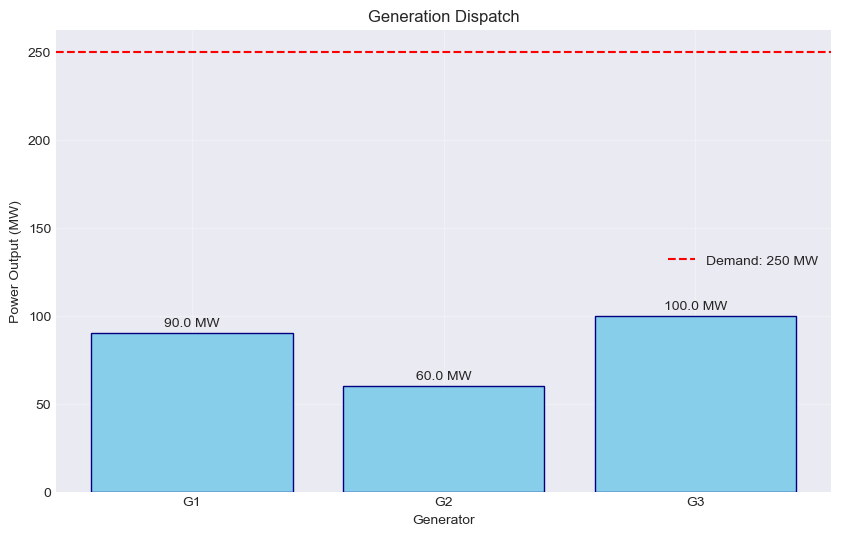

In [6]:
# Simple Economic Dispatch Example
generators = create_generator_data(n_units=3)
demand = 250  # MW

print("Generator Data:")
print(generators)

# Create and solve ED problem
prob = LpProblem("Simple_ED", LpMinimize)

# Decision variables
p = {g: LpVariable(f"p_{g}", 0) for g in generators.index}

# Objective: minimize cost
prob += lpSum(generators.loc[g, 'cost'] * p[g] for g in generators.index)

# Constraints
add_power_balance(prob, p, demand)
add_generator_limits(prob, p, generators)

# Solve and display results
results = solve_and_extract_results(prob, p)
print_optimization_results(results, "Simple Economic Dispatch")
plot_generation_dispatch(results, generators, demand);

## 2. Advanced Economic Dispatch

Real generators have more complex cost characteristics than simple linear functions. Piecewise linear costs better represent efficiency variations across the operating range, while prohibited zones capture mechanical limitations that prevent operation at certain power levels.

### Example: Piecewise Linear Costs

Many generators become less efficient at higher output levels, leading to increasing marginal costs. We model this with piecewise linear segments where each segment has a different cost slope.

When generators operate at discontinuity points between segments, the marginal cost becomes undefined, creating challenges for market pricing. The example below demonstrates how one generator operating within a segment provides a clear marginal price signal while another at a discontinuity point has an undefined marginal cost.

In [7]:
def solve_piecewise_ed(demand=265):
    """Economic dispatch with piecewise linear costs."""
    # Define generators with cost segments
    piecewise_data = {
        'G1': {
            'segments': [(50, 100, 20), (100, 150, 22), (150, 200, 25)],  # (start, end, cost)
        },
        'G2': {
            'segments': [(40, 100, 24), (100, 150, 28)],
        }
      }
    
    prob = LpProblem("Piecewise_ED", LpMinimize)
    
    # Variables for each segment
    p_seg = {}
    for g, data in piecewise_data.items():
        for i, (start, end, cost) in enumerate(data['segments']):
            p_seg[g, i] = LpVariable(f"p_{g}_{i}", 0, end - start)
    
    # Binary variables to indicate if a segment is used
    z_seg = {}
    for g, data in piecewise_data.items():
        for i in range(len(data['segments'])):
            z_seg[g, i] = LpVariable(f"z_{g}_{i}", cat='Binary')
    
    # Total generation per unit (actual power output)
    p_total = {}
    for g in piecewise_data:
        # Actual generation = minimum + sum of segment increments
        min_gen = piecewise_data[g]['segments'][0][0]
        p_total[g] = min_gen + lpSum(p_seg[g, i]
                                   for i in range(len(piecewise_data[g]['segments'])))
    
    # Objective
    prob += lpSum(
        piecewise_data[g]['segments'][i][2] * p_seg[g, i]
        for g in piecewise_data
        for i in range(len(piecewise_data[g]['segments']))
    )
    
    # Constraints
    prob += lpSum(p_total[g] for g in piecewise_data) == demand, "Power_Balance"

    # Enforce piecewise structure: segments must be filled in order
    for g in piecewise_data:
        # First segment can always be used
        if len(piecewise_data[g]['segments']) > 0:
            start, end, _ = piecewise_data[g]['segments'][0]
            prob += p_seg[g, 0] <= (end - start) * z_seg[g, 0]
    
        # Subsequent segments
        for i in range(1, len(piecewise_data[g]['segments'])):
            start, end, _ = piecewise_data[g]['segments'][i]
            start_prev, end_prev, _ = piecewise_data[g]['segments'][i-1]
    
            # Segment i can only be used if segment i-1 is full
            prob += z_seg[g, i] <= z_seg[g, i-1]
            prob += p_seg[g, i] <= (end - start) * z_seg[g, i]
            prob += p_seg[g, i-1] >= (end_prev - start_prev) * z_seg[g, i] - 0.001
    
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
      'status': LpStatus[prob.status],
      'cost': value(prob.objective),
      'generation': {g: value(p_total[g]) for g in piecewise_data},
      'lmp': prob.constraints['Power_Balance'].pi
    }
    
    return results

In [8]:
# Solve and visualize
results = solve_piecewise_ed(265)
print_optimization_results(results, "Piecewise Linear Economic Dispatch")


Piecewise Linear Economic Dispatch
Status: Optimal
Total cost: $3915.00
LMP: $25.00/MWh

Generation dispatch:
  G1: 165.0 MW
  G2: 100.0 MW


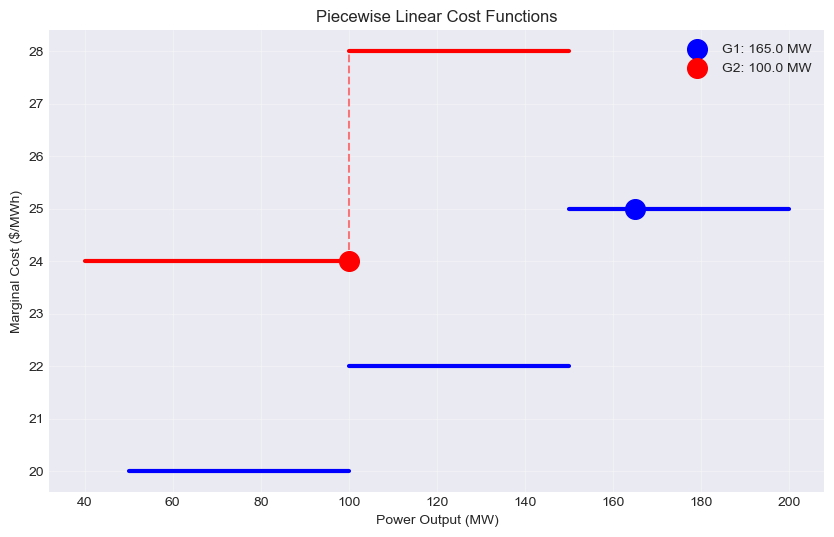

In [9]:

# Show cost curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']
for i, (g, color) in enumerate(zip(['G1', 'G2'], colors)):
    if g == 'G1':
        segments = [(50, 100, 20), (100, 150, 22), (150, 200, 25)]
    else:
        segments = [(40, 100, 24), (100, 150, 28)]
    
    # Plot the segments
    for start, end, cost in segments:
        ax.plot([start, end], [cost, cost], color=color, linewidth=3)
    
    # Mark dispatch point with correct marginal cost
    dispatch = results['generation'][g]
    
    # Find which segment the generator is operating in
    marginal_cost = None
    at_discontinuity = False
            
    
    for idx, (start, end, cost) in enumerate(segments):
        if start <= dispatch <= end:
            # Always use the cost of the current segment
            marginal_cost = cost
            
            # If at a discontinuity, still show the vertical line
            if dispatch == end and idx < len(segments) - 1:
                # At end of segment (discontinuity with next)
                next_cost = segments[idx + 1][2]
                ax.vlines(dispatch, cost, next_cost, colors=color, linestyles='dashed', alpha=0.5)
            elif dispatch == start and idx > 0:
                # At start of segment (discontinuity with previous)
                prev_cost = segments[idx - 1][2]
                ax.vlines(dispatch, prev_cost, cost, colors=color, linestyles='dashed', alpha=0.5)
            
            break
    
    # Plot dispatch point at correct cost
    y_pos = marginal_cost
    ax.scatter(dispatch, y_pos, s=200, color=color, zorder=3, 
               label=f'{g}: {dispatch:.1f} MW')
    
ax.set_xlabel('Power Output (MW)')
ax.set_ylabel('Marginal Cost ($/MWh)')
ax.set_title('Piecewise Linear Cost Functions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### Exercise 2.1: Economic Dispatch with Prohibited Zones

Some generators cannot operate in certain power ranges due to mechanical vibrations or other technical constraints. These prohibited operating zones create a more complex optimization problem that requires binary variables to ensure feasible solutions.

Implement economic dispatch for three generators where G1 cannot operate between 75-85 MW and G2 cannot operate between 110-120 MW. The total system demand is 300 MW. Your solution should use binary variables to select which operating zone each generator uses, ensuring no generator operates in its prohibited range.

**Hint:** For each generator with prohibited zones, create separate continuous variables for each allowable operating range. Use binary variables to ensure only one range is active. The sum of all zone outputs equals the generator's total output.

In [10]:
# Exercise 2.1: Your implementation here
def ed_with_prohibited_zones(demand=300):
    # Define generator data
    generators = {
        'G1': {'p_min': 50, 'p_max': 150, 'cost': 22, 'prohibited': [(75, 85)]},
        'G2': {'p_min': 40, 'p_max': 180, 'cost': 25, 'prohibited': [(110, 120)]},
        'G3': {'p_min': 30, 'p_max': 120, 'cost': 30, 'prohibited': []}
    }
    
    # Your solution here
    pass


Economic Dispatch with Prohibited Zones:
Status: Optimal
Total cost: $7200.00
LMP: $22.00/MWh

G1: 150.0 MW
G2: 120.0 MW
G3: 30.0 MW

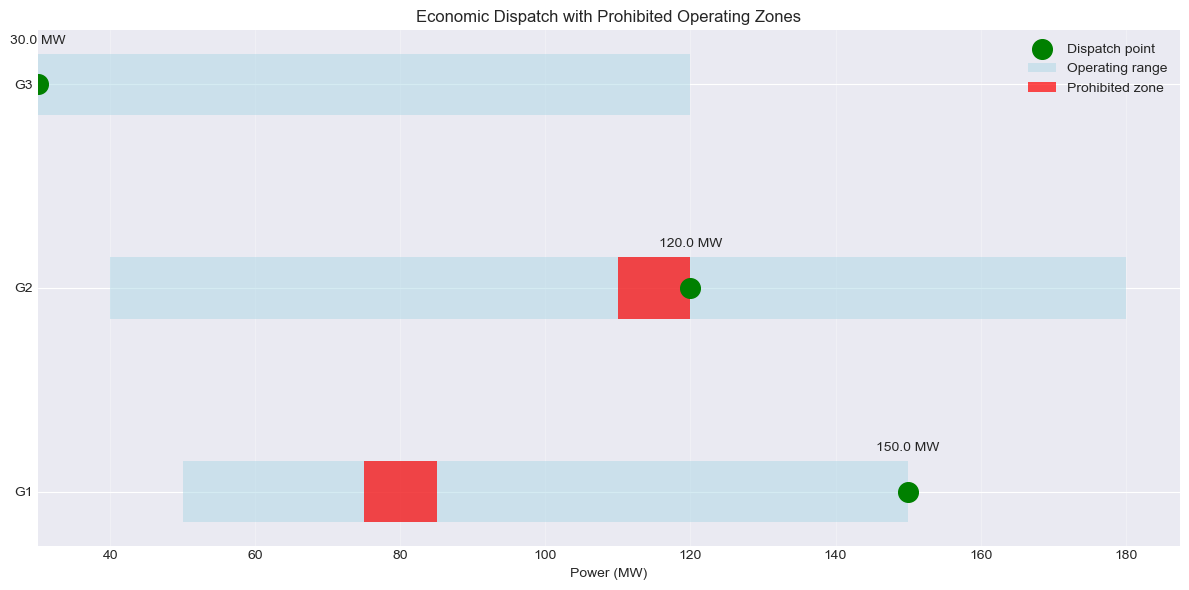

In [11]:
# Solution for Exercise 2.1: Economic Dispatch with Prohibited Zones
def ed_with_prohibited_zones(demand=300):
    """Solve ED with prohibited operating zones using binary variables."""
    prob = LpProblem("ED_Prohibited_Zones", LpMinimize)
    
    # Generator data
    generators = {
        'G1': {'p_min': 50, 'p_max': 150, 'cost': 22, 'prohibited': [(75, 85)]},
        'G2': {'p_min': 40, 'p_max': 180, 'cost': 25, 'prohibited': [(110, 120)]},
        'G3': {'p_min': 30, 'p_max': 120, 'cost': 30, 'prohibited': []}
    }
    
    # Decision variables for each operating zone
    p_zones = {}
    z_zones = {}  # Binary variables for zone selection
    
    for g_id, gen in generators.items():
        if not gen['prohibited']:
            # No prohibited zones - single operating range
            p_zones[g_id, 0] = LpVariable(f"p_{g_id}_0", gen['p_min'], gen['p_max'])
        else:
            # Create zones around prohibited regions
            zones = []
            start = gen['p_min']
            
            for prohib_start, prohib_end in gen['prohibited']:
                if prohib_start > start:
                    zones.append((start, prohib_start))
                start = prohib_end
            
            if start < gen['p_max']:
                zones.append((start, gen['p_max']))
            
            # Create variables for each zone
            for i, (z_min, z_max) in enumerate(zones):
                p_zones[g_id, i] = LpVariable(f"p_{g_id}_{i}", 0)
                z_zones[g_id, i] = LpVariable(f"z_{g_id}_{i}", cat='Binary')
                
                # Zone constraints
                prob += p_zones[g_id, i] >= z_min * z_zones[g_id, i]
                prob += p_zones[g_id, i] <= z_max * z_zones[g_id, i]
            
            # Only one zone can be active
            prob += lpSum(z_zones[g_id, i] for i in range(len(zones))) == 1
    
    # Total generation per unit
    p_total = {}
    for g_id in generators:
        if not generators[g_id]['prohibited']:
            p_total[g_id] = p_zones[g_id, 0]
        else:
            n_zones = len([k for k in p_zones if k[0] == g_id])
            p_total[g_id] = lpSum(p_zones[g_id, i] for i in range(n_zones))
    
    # Objective: minimize total cost
    prob += lpSum(generators[g_id]['cost'] * p_total[g_id] for g_id in generators)
    
    # Demand constraint
    prob += lpSum(p_total[g_id] for g_id in generators) == demand, "Demand"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Display results
    print("\nEconomic Dispatch with Prohibited Zones:")
    print(f"Status: {LpStatus[prob.status]}")
    print(f"Total cost: ${value(prob.objective):.2f}")
    print(f"LMP: ${prob.constraints['Demand'].pi:.2f}/MWh")
    
    for g_id in generators:
        gen_output = value(p_total[g_id])
        print(f"\n{g_id}: {gen_output:.1f} MW", end="")
        
        # Check if in prohibited zone (should never happen)
        for p_start, p_end in generators[g_id]['prohibited']:
            if p_start < gen_output < p_end:
                print(" (ERROR: In prohibited zone!)", end="")
    
    # Visualize the solution
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (g_id, gen) in enumerate(generators.items()):
        y_pos = i
        
        # Operating range
        ax.barh(y_pos, gen['p_max'] - gen['p_min'], left=gen['p_min'], 
                height=0.3, color='lightblue', alpha=0.5, label='Operating range' if i==0 else '')
        
        # Prohibited zones
        for p_start, p_end in gen['prohibited']:
            ax.barh(y_pos, p_end - p_start, left=p_start, 
                    height=0.3, color='red', alpha=0.7, label='Prohibited zone' if i==0 else '')
        
        # Actual generation
        gen_value = value(p_total[g_id])
        ax.scatter(gen_value, y_pos, s=200, color='green', zorder=3, 
                   label='Dispatch point' if i==0 else '')
        ax.text(gen_value, y_pos + 0.2, f'{gen_value:.1f} MW', ha='center')
    
    ax.set_yticks(range(3))
    ax.set_yticklabels(['G1', 'G2', 'G3'])
    ax.set_xlabel('Power (MW)')
    ax.set_title('Economic Dispatch with Prohibited Operating Zones')
    ax.legend()
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return prob, p_total

# Run the solution
prob, p_total = ed_with_prohibited_zones(300)

## 3. Unit Commitment

Unit commitment extends economic dispatch by determining not just how much each generator produces, but also when to start up or shut down units. This mixed-integer optimization problem balances operating costs against startup costs while respecting technical constraints like minimum run times.

Let's start with a simplified example before tackling the full formulation.

### Example: Simple Unit Commitment

We'll solve unit commitment for a small system over 6 hours, focusing on the core concepts of binary commitment decisions and startup costs.

In [12]:
def simple_unit_commitment():
    """Simplified UC for 3 units over 8 hours with clear on/off behavior."""
    # Create more distinctive generator characteristics
    generators = pd.DataFrame({
        'p_min': [100, 30, 20],      # G1 has high minimum (base load)
        'p_max': [200, 150, 80],     # Different capacities
        'cost': [10, 25, 50],        # Significant cost differences
        'startup_cost': [500, 2000, 1000],  # G2 has high startup cost
        'initial_status': [1, 0, 0],  # Only G1 starts on
        'initial_power': [150, 0, 0]
    }, index=['G1_Base', 'G2_Mid', 'G3_Peak'])
    
    hours = 8
    # Create demand profile that forces unit cycling
    demand = np.array([120, 130, 180, 250, 360, 350, 200, 140])
    
    # Display data
    print("Generator Data:")
    print(generators[['p_min', 'p_max', 'cost', 'startup_cost']])
    print(f"\nDemand: {demand}")
    
    # Create problem
    prob = LpProblem("Simple_UC", LpMinimize)
    periods = range(hours)
    
    # Variables
    u = {}  # Unit on/off
    p = {}  # Power output
    v = {}  # Startup indicator
    
    for g in generators.index:
        for t in periods:
            u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
            p[g,t] = LpVariable(f"p_{g}_{t}", 0)
            v[g,t] = LpVariable(f"v_{g}_{t}", cat='Binary')
    
    # Objective
    operating_cost = lpSum(generators.loc[g, 'cost'] * p[g,t] 
                          for g in generators.index for t in periods)
    startup_cost = lpSum(generators.loc[g, 'startup_cost'] * v[g,t]
                        for g in generators.index for t in periods)
    prob += operating_cost + startup_cost
    
    # Constraints
    for t in periods:
        # Power balance
        prob += lpSum(p[g,t] for g in generators.index) == demand[t]
        
        # Reserve (simplified - 5% of demand)
        prob += lpSum(generators.loc[g, 'p_max'] * u[g,t] 
                     for g in generators.index) >= 1.05 * demand[t]
    
    for g in generators.index:
        for t in periods:
            # Generation limits
            prob += p[g,t] >= generators.loc[g, 'p_min'] * u[g,t]
            prob += p[g,t] <= generators.loc[g, 'p_max'] * u[g,t]
            
            # Startup logic
            if t == 0:
                prob += v[g,t] >= u[g,t] - generators.loc[g, 'initial_status']
            else:
                prob += v[g,t] >= u[g,t] - u[g,t-1]
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    schedule = pd.DataFrame(index=generators.index, columns=periods)
    generation = pd.DataFrame(index=generators.index, columns=periods)
    
    for g in generators.index:
        for t in periods:
            schedule.loc[g, t] = int(value(u[g,t]))
            generation.loc[g, t] = value(p[g,t]) if schedule.loc[g, t] else 0
    
    return schedule, generation, demand, value(prob.objective)


In [13]:
# Solve and visualize
schedule, generation, demand, total_cost = simple_unit_commitment()

print(f"\nTotal cost: ${total_cost:,.0f}")
print("\nUnit Schedule (1=ON, 0=OFF):")
print(schedule)
print("\nStartup events:")
for g in generation.index:
    startups = []
    for t in range(len(demand)):
        if t == 0 and schedule.loc[g, 0] == 1 and g != 'G1_Base':  # G1 was already on
            startups.append(0)
        elif t > 0 and schedule.loc[g, t] == 1 and schedule.loc[g, t-1] == 0:
            startups.append(t)
    if startups:
        print(f"{g}: hours {startups}")

print("\nShutdown events:")
for g in generation.index:
    shutdowns = []
    for t in range(len(demand)):
        if t > 0 and schedule.loc[g, t] == 0 and schedule.loc[g, t-1] == 1:
            shutdowns.append(t)
    if shutdowns:
        print(f"{g}: hours {shutdowns}")

Generator Data:
         p_min  p_max  cost  startup_cost
G1_Base    100    200    10           500
G2_Mid      30    150    25          2000
G3_Peak     20     80    50          1000

Demand: [120 130 180 250 360 350 200 140]

Total cost: $27,150

Unit Schedule (1=ON, 0=OFF):
         0  1  2  3  4  5  6  7
G1_Base  1  1  1  1  1  1  1  1
G2_Mid   0  0  0  1  1  1  1  0
G3_Peak  0  0  0  0  1  1  0  0

Startup events:
G2_Mid: hours [3]
G3_Peak: hours [4]

Shutdown events:
G2_Mid: hours [7]
G3_Peak: hours [6]


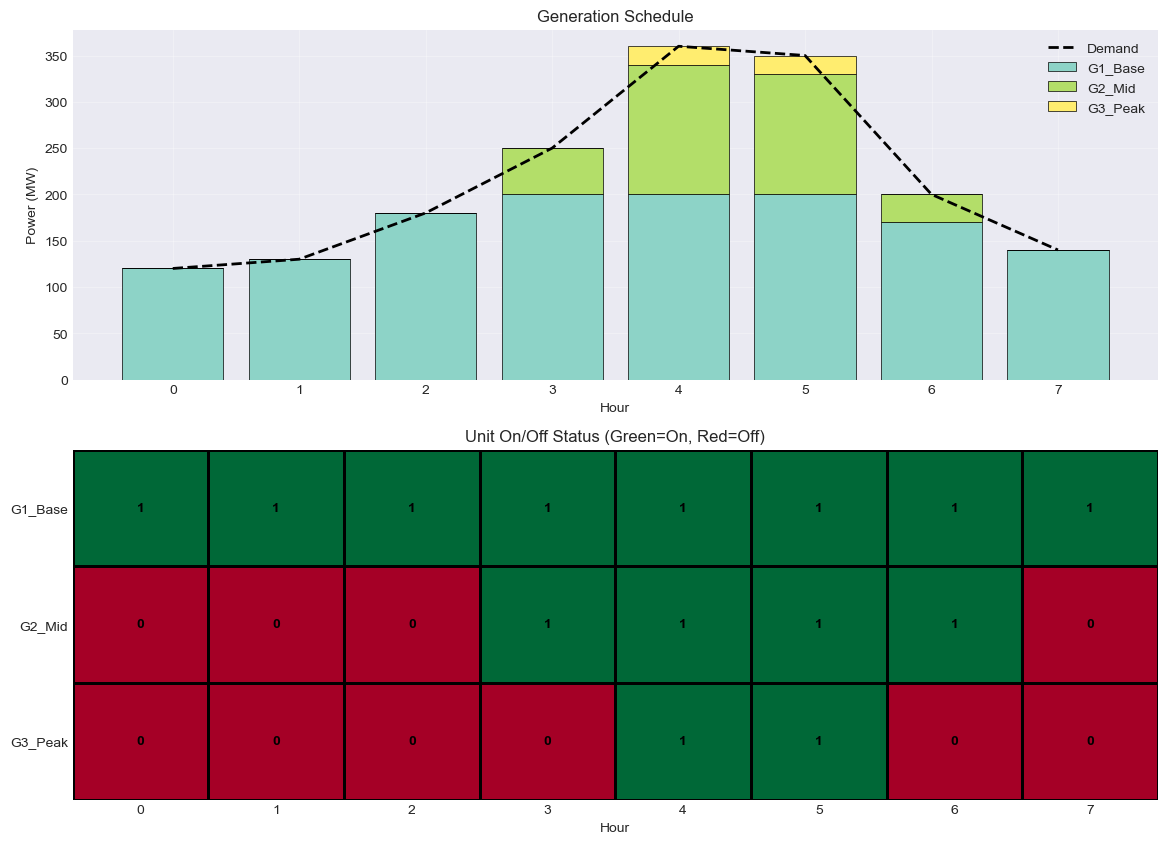

In [14]:
fig, ax = plot_unit_commitment_schedule(schedule, generation, demand)

### Exercise 3.1: Full Unit Commitment with Technical Constraints

Real unit commitment problems include additional technical constraints that ensure feasible generator operation. Minimum up and down times prevent excessive cycling that would damage equipment, while ramping limits restrict how quickly generators can change output.

Extend the simple unit commitment to include minimum up/down time constraints and ramping limits for a 24-hour period. Use the provided generator data which includes these technical parameters. Your formulation should ensure that once a unit starts up, it remains on for at least its minimum up time, and similarly for shutdowns.

**Hint:** For minimum up time of 4 hours, if a unit starts at hour t, it must remain on through hour t+3. Use the startup variable v[g,t] to trigger these constraints. Ramping constraints limit the change in output between consecutive hours but must account for startup and shutdown transitions.

In [20]:
# Exercise 3.1: Your implementation here
def full_unit_commitment():
    # Load data
    tot_hours = 24
    generators = create_generator_data(n_units=3, include_startup=True)
    demand = create_demand_profile(hours=tot_hours)
    
    # Display the data
    plot_demand_profile(demand)
    plt.show()
    
    print("Generator Data:")
    print(generators)
    
    # Your implementation here
    pass

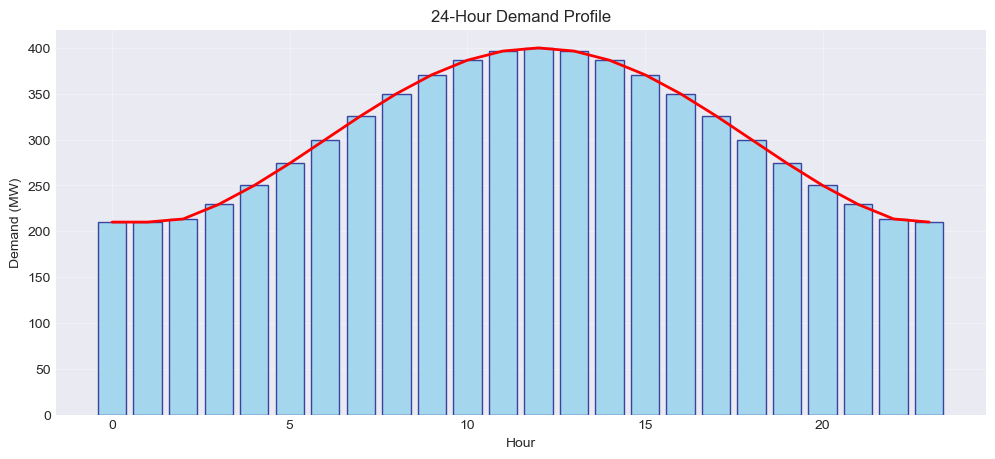

Generator Data:
    p_min  p_max  cost  startup_cost  min_up  min_down  ramp_up  ramp_down  \
G1   20.0  100.0  20.0        1000.0       2         2     20.0       20.0   
G2   60.0  250.0  27.5        3000.0       4         4     50.0       50.0   
G3  100.0  400.0  35.0        5000.0       8         8     80.0       80.0   

    initial_status  initial_power  
G1               1           20.0  
G2               1           60.0  
G3               0            0.0  

Unit Commitment Results:
Status: Optimal
Total cost: $202,877
Solve time: 0.43 seconds


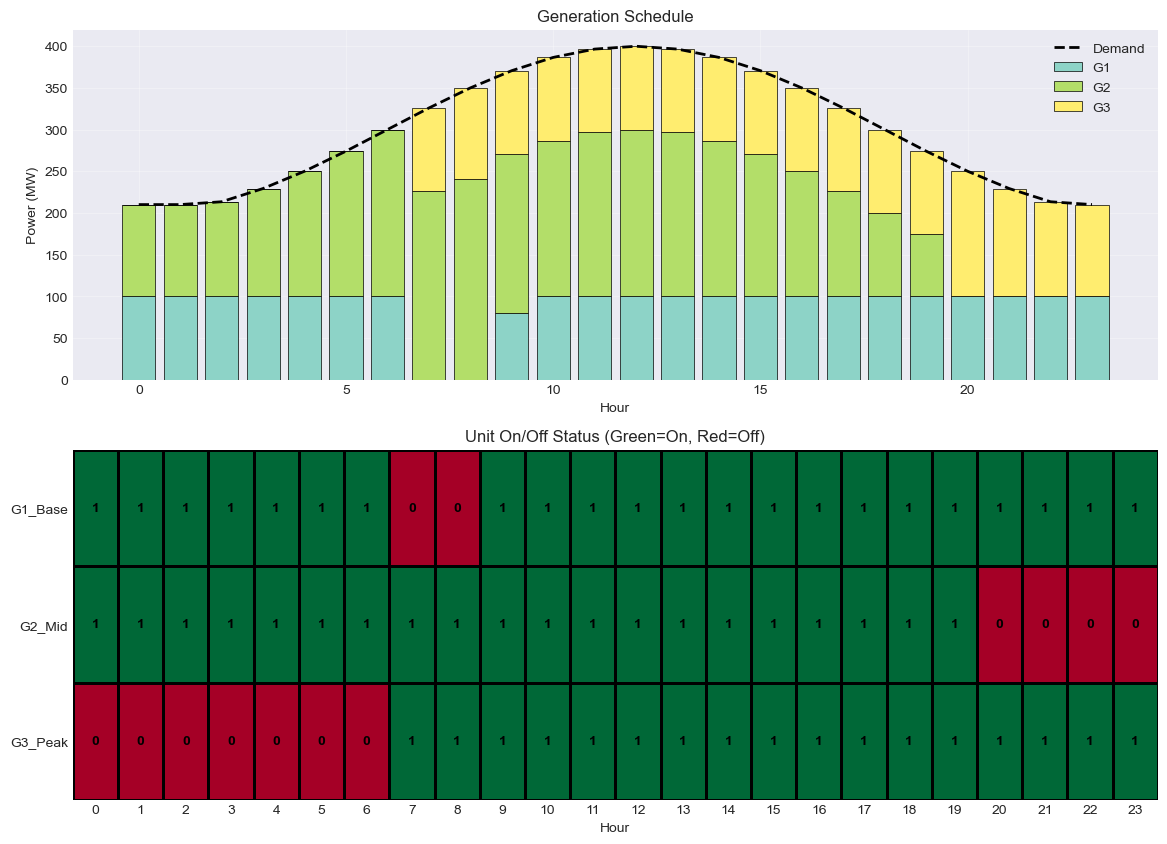


Cost Breakdown:
Operating cost: $195,877
Startup cost: $7,000

Startup events:
G1: hours [0, 9]
G3: hours [7]


In [19]:
# Solution for Exercise 3.1: Full Unit Commitment with Technical Constraints
def full_unit_commitment():
    """Complete UC formulation with all technical constraints."""
    # Load data
    tot_hours = 24
    generators = create_generator_data(n_units=3, include_startup=True)
    demand = create_demand_profile(hours=tot_hours)
    T = len(demand)
    periods = range(T)
    gen_names = generators.index.tolist()
    
    # Display the data
    plot_demand_profile(demand)
    plt.show()
    
    print("Generator Data:")
    print(generators)
    
    # Create problem
    prob = LpProblem("Full_Unit_Commitment", LpMinimize)
    
    # Decision variables
    u = {}  # Unit on/off
    p = {}  # Power output
    v = {}  # Startup indicator
    w = {}  # Shutdown indicator
    
    for g in gen_names:
        for t in periods:
            u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
            p[g,t] = LpVariable(f"p_{g}_{t}", 0)
            v[g,t] = LpVariable(f"v_{g}_{t}", cat='Binary')
            w[g,t] = LpVariable(f"w_{g}_{t}", cat='Binary')
    
    # Objective: minimize total cost
    prob += lpSum(
        generators.loc[g, 'cost'] * p[g,t] + 
        generators.loc[g, 'startup_cost'] * v[g,t]
        for g in gen_names for t in periods
    )
    
    # Constraints
    for t in periods:
        # Demand constraint
        prob += lpSum(p[g,t] for g in gen_names) == demand[t], f"Demand_{t}"
        
        # Reserve constraint (10% of demand)
        prob += lpSum(
            generators.loc[g, 'p_max'] * u[g,t] - p[g,t] 
            for g in gen_names
        ) >= 0.1 * demand[t], f"Reserve_{t}"
    
    for g in gen_names:
        for t in periods:
            # Generation limits
            prob += p[g,t] >= generators.loc[g, 'p_min'] * u[g,t], f"P_min_{g}_{t}"
            prob += p[g,t] <= generators.loc[g, 'p_max'] * u[g,t], f"P_max_{g}_{t}"
            
            # Startup/shutdown logic
            if t == 0:
                # Initial conditions
                initial_u = generators.loc[g, 'initial_status']
                prob += v[g,t] >= u[g,t] - initial_u, f"Startup_{g}_{t}"
                prob += w[g,t] >= initial_u - u[g,t], f"Shutdown_{g}_{t}"
            else:
                prob += v[g,t] >= u[g,t] - u[g,t-1], f"Startup_{g}_{t}"
                prob += w[g,t] >= u[g,t-1] - u[g,t], f"Shutdown_{g}_{t}"
            
            # Ramping constraints
            if t > 0:
                # Ramp up
                prob += (p[g,t] - p[g,t-1] <= 
                        generators.loc[g, 'ramp_up'] * u[g,t-1] + 
                        generators.loc[g, 'p_max'] * v[g,t]), f"RampUp_{g}_{t}"
                # Ramp down
                prob += (p[g,t-1] - p[g,t] <= 
                        generators.loc[g, 'ramp_down'] * u[g,t] + 
                        generators.loc[g, 'p_max'] * w[g,t]), f"RampDown_{g}_{t}"
            else:
                # Initial ramping from initial power
                initial_p = generators.loc[g, 'initial_power']
                initial_u = generators.loc[g, 'initial_status']
                prob += (p[g,t] - initial_p <= 
                        generators.loc[g, 'ramp_up'] * initial_u + 
                        generators.loc[g, 'p_max'] * v[g,t]), f"RampUp_{g}_{t}"
    
    # Minimum up/down time constraints
    for g in gen_names:
        min_up = int(generators.loc[g, 'min_up'])
        min_down = int(generators.loc[g, 'min_down'])
        
        # Minimum up time
        for t in periods:
            t_end = min(t + min_up, T)
            if t_end > t:
                prob += (lpSum(u[g,k] for k in range(t, t_end)) >= 
                        min_up * v[g,t]), f"MinUp_{g}_{t}"
        
        # Minimum down time
        for t in periods:
            t_end = min(t + min_down, T)
            if t_end > t:
                prob += (lpSum(1 - u[g,k] for k in range(t, t_end)) >= 
                        min_down * w[g,t]), f"MinDown_{g}_{t}"
    
    # Solve
    start_time = time.time()
    prob.solve(PULP_CBC_CMD(timeLimit=60, msg=0))
    solve_time = time.time() - start_time
    
    print(f"\nUnit Commitment Results:")
    print(f"Status: {LpStatus[prob.status]}")
    print(f"Total cost: ${value(prob.objective):,.0f}")
    print(f"Solve time: {solve_time:.2f} seconds")
    
    # Create commitment schedule - ensure numeric types
    schedule = pd.DataFrame(index=generators.index, columns=list(range(tot_hours)))
    generation = pd.DataFrame(index=generators.index, columns=list(range(tot_hours)))
    
    for g in generators.index:
        for t in range(tot_hours):
            u_val = value(u[g,t])
            p_val = value(p[g,t])
            
            # Ensure we have numeric values
            schedule.loc[g, t] = 1 if u_val > 0.5 else 0
            generation.loc[g, t] = p_val if u_val > 0.5 else 0.0
    
    # Visualize results
    fig = plot_unit_commitment_schedule(schedule, generation, demand)
    plt.show()
    
    # Summary statistics
    total_startup_cost = sum(generators.loc[g, 'startup_cost'] * value(v[g,t]) 
                             for g in generators.index for t in range(tot_hours))
    total_operating_cost = value(prob.objective) - total_startup_cost
    
    print(f"\nCost Breakdown:")
    print(f"Operating cost: ${total_operating_cost:,.0f}")
    print(f"Startup cost: ${total_startup_cost:,.0f}")
    print(f"\nStartup events:")
    for g in generators.index:
        startups = [t for t in range(tot_hours) if value(v[g,t]) > 0.5]
        if startups:
            print(f"{g}: hours {startups}")
    
    return prob, u, p, v, w

# Run the solution
prob, u, p, v, w = full_unit_commitment()

## Summary

This lesson demonstrated how optimization techniques solve critical power system operational challenges. We progressed from basic economic dispatch through unit commitment with technical constraints. Those optimization models are run daily in numerous system operators. 

Next, we will discuss security-constrained optimization for reliability, optimal power flow formulations, and renewable integration.